# NUC Product Classifier

Implementing a ML model to automatically label product descriptions according to State of Santa Catarina NUC id. A final assessment study presented to PUCRS Data Processing and AI Specialization Course.

Disclaimer: all content extracted are for educational purposes only. None of the content will be used commercially. No infringement intended.

In [147]:
# Install libraries.

# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install selenium
# !{sys.executable} -m pip install webdriver-manager
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install wordcloud
# !{sys.executable} -m pip install --upgrade Pillow
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download 'pt_core_news_sm'
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install scikit-learn

     ------------------------------------ 210.7/210.7 kB 346.7 kB/s eta 0:00:00
  Obtaining dependency information for cytoolz>=0.10.1 from https://files.pythonhosted.org/packages/b0/5c/13fc01ed00fa4818c9bcbe1e0bdb71af5f972faaf84986a463a93e17479b/cytoolz-0.12.2-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for floret~=0.10.0 from https://files.pythonhosted.org/packages/08/cf/d11e15aba9d9f08317bd62380045eee588f47bfc6ece6fde62502cd28b2d/floret-0.10.4-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for jellyfish>=0.8.0 from https://files.pythonhosted.org/packages/f1/26/d91ceb4de9210074fc8f9ddfea98e471e48576dff2d0a252ada4315e0f80/jellyfish-1.0.0-cp310-none-win_amd64.whl.metadata
     ---------------------------------------- 2.1/2.1 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 55.8/55.8 kB 3.0 MB/s eta 0:00:00
   -------------------------------

In [59]:
# Import libraries.

from selenium import webdriver
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from time import sleep
from random import randint
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
import numpy as np
import pandas as pd
import nltk
import spacy

## Building the dataset

In [60]:
# Implementing scraping functions to build dataframe.

def random_wait():
    """Establishes script level random sleep time to prevent exception before page load is complete."""
    sleep(randint(2, 5))


def pre_check(product: str, product_title: str):
    """Pre-check if item found in search corresponds to product."""
    matches = re.split("\s+", product.lower())
    return all([x in product_title.lower() for x in matches])


def pre_clean_text(text: str):
    """"Removes multiple whitespaces."""
    return re.sub('[\n]', ' ', text).strip()


def pre_clean_price(price: str):
    """Return price raw value."""
    return re.sub(r"[R$.]", "", price).replace(",", ".")


def search_amazon(product: str, nuc_id: str, n_results: int = 10):
    """Perform product search on Amazon and returns description related data."""
    driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()))
    wait = WebDriverWait(driver, timeout=5)
    driver.get("https://www.amazon.com.br/")
    driver.maximize_window()
    random_wait()

    search_input = wait.until(EC.presence_of_element_located((
        By.XPATH, '//input[@placeholder="Pesquisa Amazon.com.br"]')))
    search_input.send_keys(product, Keys.ENTER)
    random_wait()

    search_results = driver.find_elements(
        By.XPATH, '//div[@data-component-type="s-search-result"]')
    
    items_urls = []
    for item in search_results:
        item_url = item.find_element(
            By.XPATH, './/a').get_attribute('href')
        items_urls.append(item_url)

    original_window = driver.current_window_handle
    
    products_descriptions = []
    for url in items_urls[:n_results]:
        driver.switch_to.new_window('tab')
        driver.get(url)
        random_wait()

        try:
            product_title = driver.find_element(By.ID, "productTitle").text
            product_price = driver.find_element(
                By.XPATH, '//span[@class="a-price aok-align-center"]/span[@class="a-offscreen"]').get_attribute("textContent")
            product_description = driver.find_element(
                By.ID, "productDescription").text
            # product_features = driver.find_element(
            #     By.ID, "productOverview_feature_div").text
            # product_main_features = driver.find_element(
            #     By.ID, "featurebullets_feature_div").text
            product_spec = driver.find_element(
                By.ID, "productDetails_techSpec_section_1").text
        except:
            driver.close()
            driver.switch_to.window(original_window)
            continue
        
        if pre_check(product, product_title + product_description + product_spec):
            products_descriptions.append({
                "source": "amazon",
                "product_title": pre_clean_text(product_title),
                "product_description": pre_clean_text(product_description),
                # "product_features": product_features,
                # "product_main_features": product_main_features,
                "product_spec": pre_clean_text(product_spec),
                "product_price": pre_clean_price(product_price),
                "product_nuc": nuc_id,
            })

        driver.close()
        driver.switch_to.window(original_window)
    
    driver.quit()

    return products_descriptions


def search_magalu(product: str, nuc_id: str, n_results: int = 10):
    """Perform product search on Magazine Luiza and returns description related data."""
    driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()))
    wait = WebDriverWait(driver, timeout=5)
    driver.get("https://www.magazineluiza.com.br/")
    driver.maximize_window()
    random_wait()

    search_input = wait.until(EC.presence_of_element_located((
        By.XPATH, '//input[@placeholder="Busca no Magalu"]')))
    search_input.send_keys(product, Keys.ENTER)
    random_wait()

    search_results = driver.find_elements(
        By.XPATH, '//a[@data-testid="product-card-container"]')
    
    items_urls = []
    for item in search_results:
        item_url = item.get_attribute('href')
        items_urls.append(item_url)

    original_window = driver.current_window_handle

    products_descriptions = []
    for url in items_urls[:n_results]:
        driver.switch_to.new_window('tab')
        driver.get(url)
        random_wait()

        try:
            product_title = driver.find_element(
                By.XPATH, "//h1[@data-testid='heading-product-title']").text
            product_price = driver.find_element(
                By.XPATH, "//*[@data-testid='price-value']").text
            product_description = driver.find_element(
                By.XPATH, "//*[@data-testid='product-detail']").text
            product_spec = driver.find_element(
                By.XPATH, "//div/table").text
        except:
            driver.close()
            driver.switch_to.window(original_window)
            continue

        if pre_check(product, product_title + product_description + product_spec):
            products_descriptions.append({
                "source": "magalu",
                "product_title": pre_clean_text(product_title),
                "product_description": pre_clean_text(product_description),
                "product_spec": pre_clean_text(product_spec),
                "product_price": pre_clean_price(product_price),
                "product_nuc": nuc_id,
            })

        driver.close()
        driver.switch_to.window(original_window)
    
    driver.quit()

    return products_descriptions

In [3]:
# Collecting product's marketplace descriptions and labelling with NUC id. 

n_results = 30
search_arguments = [{"product": "ar condicionado 9000 btu", "nuc_id": "123579003"}, {
    "product": "tablet", "nuc_id": "004723356"}]

data = []
for item in search_arguments:
    amazon_results = search_amazon(item["product"], item["nuc_id"], n_results)
    data.extend(amazon_results)
    random_wait()
    magalu_results = search_magalu(item["product"], item["nuc_id"], n_results)
    data.extend(magalu_results)
    random_wait()


data[:5]

[{'source': 'amazon',
  'product_title': 'Ar Condicionado Split Inverter Philco 9000 BTUs Quente/Frio 220V PAC9000ITQFM9W',
  'product_description': 'Ar Condicionado Split Inverter Philco 9000 BTUs Quente/Frio 220V PAC9000ITQFM9W O Ar Condicionado Split Inverter Philco 9000 BTUs Quente/Frio 220V é a escolha perfeita para quem busca conforto em todas as estações do ano. Com a tecnologia Inverter, o aparelho ajusta automaticamente a velocidade do compressor de acordo com a temperatura do ambiente, proporcionando uma economia de até 60% no consumo de energia elétrica. Com capacidade de 9000 BTUs, é indicado para ambientes de pequeno porte, como quartos e salas. Sua função quente/frio permite que o aparelho possa ser utilizado tanto no verão quanto no inverno, mantendo o ambiente agradável em todas as épocas. Especificações técnicas: - Marca: Philco - Modelo: PAC9000ITQFM9W - Voltagem: 220V - Cor: Branco - Potência: 1080W - Serpentina: Cobre - Consumo: 15,9 kWh - Ciclos de ar: Quente e Fri

In [4]:
# Creating dataset

df = pd.DataFrame(data)

df.head()


,source,product_title,product_description,product_spec,product_price,product_nuc
0,amazon,Ar Condicionado Split Inverter Philco 9000 BTU...,Ar Condicionado Split Inverter Philco 9000 BTU...,Nome da marca PHILCO Informações do modelo PAC...,1999.00,123579003
1,amazon,Ar Condicionado Split LG 9000 BTUs Dual Invert...,Ar Condicionado Split LG 9000 BTUs Dual Invert...,Marca LG Número da peça B0BD5LWK5W Característ...,2149.00,123579003
2,amazon,Ar Condicionado Split Samsung Digital Inverter...,Especificações Técnicas: Marca: Samsung Modelo...,"Peso do produto 20,8 Quilogramas Voltagem 220 ...",1899.00,123579003
3,amazon,Ar-Condicionado Split HW Philco PAS9500FA1 9.0...,Ar-Condicionado Split HW Philco 9.000 BTUs Só ...,Nome da marca PHILCO Dimensões do produto 27 x...,1429.00,123579003
4,amazon,Ar Condicionado Split High Wall Springer Midea...,O Ar-Condicionado Springer Midea AirVolution é...,Nome da marca Midea Dimensões do produto 47 x ...,1688.99,123579003


In [5]:
#  Saving dataset csv

df.to_csv("data.csv", index=False)

## Cleaning data

In [61]:
# Load csv dataset file with pandas

dataset = pd.read_csv("data.csv")

dataset

,source,product_title,product_description,product_spec,product_price,product_nuc
0,amazon,Ar Condicionado Split Inverter Philco 9000 BTU...,Ar Condicionado Split Inverter Philco 9000 BTU...,Nome da marca PHILCO Informações do modelo PAC...,1999.00,123579003
1,amazon,Ar Condicionado Split LG 9000 BTUs Dual Invert...,Ar Condicionado Split LG 9000 BTUs Dual Invert...,Marca LG Número da peça B0BD5LWK5W Característ...,2149.00,123579003
2,amazon,Ar Condicionado Split Samsung Digital Inverter...,Especificações Técnicas: Marca: Samsung Modelo...,"Peso do produto 20,8 Quilogramas Voltagem 220 ...",1899.00,123579003
3,amazon,Ar-Condicionado Split HW Philco PAS9500FA1 9.0...,Ar-Condicionado Split HW Philco 9.000 BTUs Só ...,Nome da marca PHILCO Dimensões do produto 27 x...,1429.00,123579003
4,amazon,Ar Condicionado Split High Wall Springer Midea...,O Ar-Condicionado Springer Midea AirVolution é...,Nome da marca Midea Dimensões do produto 47 x ...,1688.99,123579003
...,...,...,...,...,...,...
75,magalu,"Tablet Samsung Galaxy A7 Lite 8,7” Wi-Fi 32GB ...",Informações do Produto Tablet Samsung Galaxy A...,Marca samsung Referência SM-T220NZAPZTO Modelo...,1016.10,4723356
76,magalu,Tablet Philco PTB8RRG 8” 4G Wi-Fi 32GB - Andro...,Informações do Produto Tablet Philco PTB8RRG 8...,Marca Philco Referência 58203022 Modelo PTB8RR...,648.21,4723356
77,magalu,"Tablet Samsung Galaxy A7 Lite 8,7” 4G Wi-Fi 32...",Informações do Produto Tablet Samsung Galaxy A...,Marca samsung Referência SM-T225NZAPZTO Modelo...,1070.10,4723356
78,magalu,"Tablet Positivo Twist Tab 7 Pol"" 64Gb 2Gb Ram ...",Informações do Produto Tablet Positivo Twist T...,Informações complementares Cor Cinza Marca Pos...,422.91,4723356


In [204]:
# Create a dataframe joining product_title, product_description and product_spec as a unique column aside with nuc_id

df = pd.DataFrame()
df["product_information"] = dataset["product_title"].str.cat(dataset[["product_description", "product_spec"]], sep=" ")
df["nuc_id"] = dataset.product_nuc

df.sample(5)

,product_information,nuc_id
22,Ar Condicionado Split Hi Wall Philco 9000 BTU/...,123579003
29,Ar Condicionado Split Hi Wall Consul Maxi 9000...,123579003
0,Ar Condicionado Split Inverter Philco 9000 BTU...,123579003
25,Ar Condicionado Split Hi Wall Inverter LG Dual...,123579003
26,Ar Condicionado Split Inverter 9000 BTUs Frio ...,123579003


In [205]:
# Implement a clean text function

nltk.download("stopwords")

def clean_text(text: str):
    """"Removes stopwords, multiple whitespaces, punctuation and converts string to lowercase."""
    stopwords = nltk.corpus.stopwords.words('portuguese')
    text_ = text.translate(str.maketrans('', '', string.punctuation)).lower().split()
    return " ".join([word for word in text_ if not word in set(stopwords)])

df["product_information"] = df["product_information"].apply(clean_text)

df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Agilulfo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,product_information,nuc_id
0,ar condicionado split inverter philco 9000 btu...,123579003
1,ar condicionado split lg 9000 btus dual invert...,123579003
2,ar condicionado split samsung digital inverter...,123579003
3,arcondicionado split hw philco pas9500fa1 9000...,123579003
4,ar condicionado split high wall springer midea...,123579003


In [64]:
# Lemmatization

nlp = spacy.load("pt_core_news_sm")

def lemmatize(text: str):
    """Returns lemmatized text"""
    return " ".join([token.lemma_ for token in nlp(text)])


df["product_information"] = df["product_information"].apply(lemmatize)

df["product_information"]

0     ar condicionado splitr inverter philco 9000 bt...
1     ar condicionado splitr lg 9000 btus dual inver...
2     ar condicionado splitr samsung digital inverte...
3     arcondicionar split hw philco pas9500fa1 9000 ...
4     ar condicionado splitr high Wall springer Mide...
                            ...                        
75    tabletr samsung Galaxy a7 lite 87 ” wifi 32 gb...
76    tablet philco ptb8rrg 8 ” 4 g wifi 32 gb andro...
77    tabletr samsung Galaxy a7 lite 87 ” 4 g wifi 3...
78    tablet positivo twist tab 7 pol 64 gb 2 gb r t...
79    tablet galaxy a7 lite smt220nzapzto wifi 32 gb...
Name: product_information, Length: 80, dtype: object

In [6]:
# Create a Corpus

corpus = [text for text in df.product_information]

corpus[:5]


['ar condicionado splitr inverter philco 9000 btus quentefrio 220v pac9000itqfm9w ar condicionado splitr inverter philco 9000 btus quentefrio 220v pac9000itqfm9w ar condicionado splitr inverter philco 9000 btus quentefrio 220v escolha perfazer buscar conforto todo estação ano tecnologia inverter aparelho ajustar automaticamente velocidade compressor acordo temperatura ambiente proporcionar economia 60 consumo energia elétrico capacidade 9000 btus indicar ambiente pequeno porte quarto sala função quentefrio permitir aparelho poder utilizar tanto ver quanto inverno manter ambiente agradável todo época especificação técnico marca philco modelo pac9000itqfm9w voltagem 220v cor branco potência 1080w serpentina cobrir consumo 159 kwh ciclo ar quente frio capacidade 9000 Btuh gás ecológico r410a pintura anticorrosivo sim classe eficiência energético sim controle temperatura digital 16 ° c 32 ° c modo operação esfriar aquecer desumidificar ventilar automático função dormir oscilar timer contro

## Creating the Bag of Words model

In [141]:
def word_frequency(texts):
    """Print word frequency values"""
    for _ in texts:
        print(Counter(_.split()).most_common(10))


def word_frequency_barchart(texts, title: str):
    """Plot word frequency bar chart"""
    counter = Counter(" ".join(texts).split())

    labels = []
    values = []

    for label, value in counter.most_common(20):
        labels.append(label)
        values.append(value)

    # labels, values
    plt.figure(figsize=(24, 12))
    plt.title(title, fontsize=20)
    plt.ylabel("Frequency", fontsize=15)
    plt.xlabel("Term", fontsize=15)
    plt.xticks(rotation=90, fontsize=12)
    plt.bar(labels, values, width=0.8)
    plt.show()


def wordcloud(texts):
    """Plot wordcloud chart"""
    wordcloud = WordCloud(width=800, height=500,
                          max_font_size=80).generate(" ".join(texts))

    plt.figure(figsize=(24, 12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [136]:
# Word frequency air conditioner

word_frequency(df.product_information[1:41].sample(5))

[('gree', 9), ('filtro', 5), ('split', 4), ('grande', 4), ('Plus', 3), ('garantir', 3), ('proteção', 3), ('ano', 3), ('produção', 3), ('eletrodoméstico', 3)]
[('unidade', 12), ('sim', 12), ('x', 10), ('inverter', 8), ('ar', 7), ('lg', 7), ('interno', 7), ('dual', 6), ('externo', 6), ('voice', 5)]
[('ar', 5), ('btus', 5), ('ambiente', 5), ('convencional', 4), ('9000', 4), ('frio', 4), ('tclr', 4), ('splitr', 3), ('mod', 3), ('01', 3)]
[('inverter', 12), ('ar', 11), ('sim', 10), ('samsung', 9), ('garantir', 8), ('9000', 7), ('compressor', 7), ('condensador', 7), ('vento', 6), ('quente', 6)]
[('ar', 6), ('função', 4), ('philco', 3), ('frio', 3), ('9000', 3), ('unidade', 3), ('controle', 3), ('condicionado', 2), ('splitr', 2), ('wall', 2)]


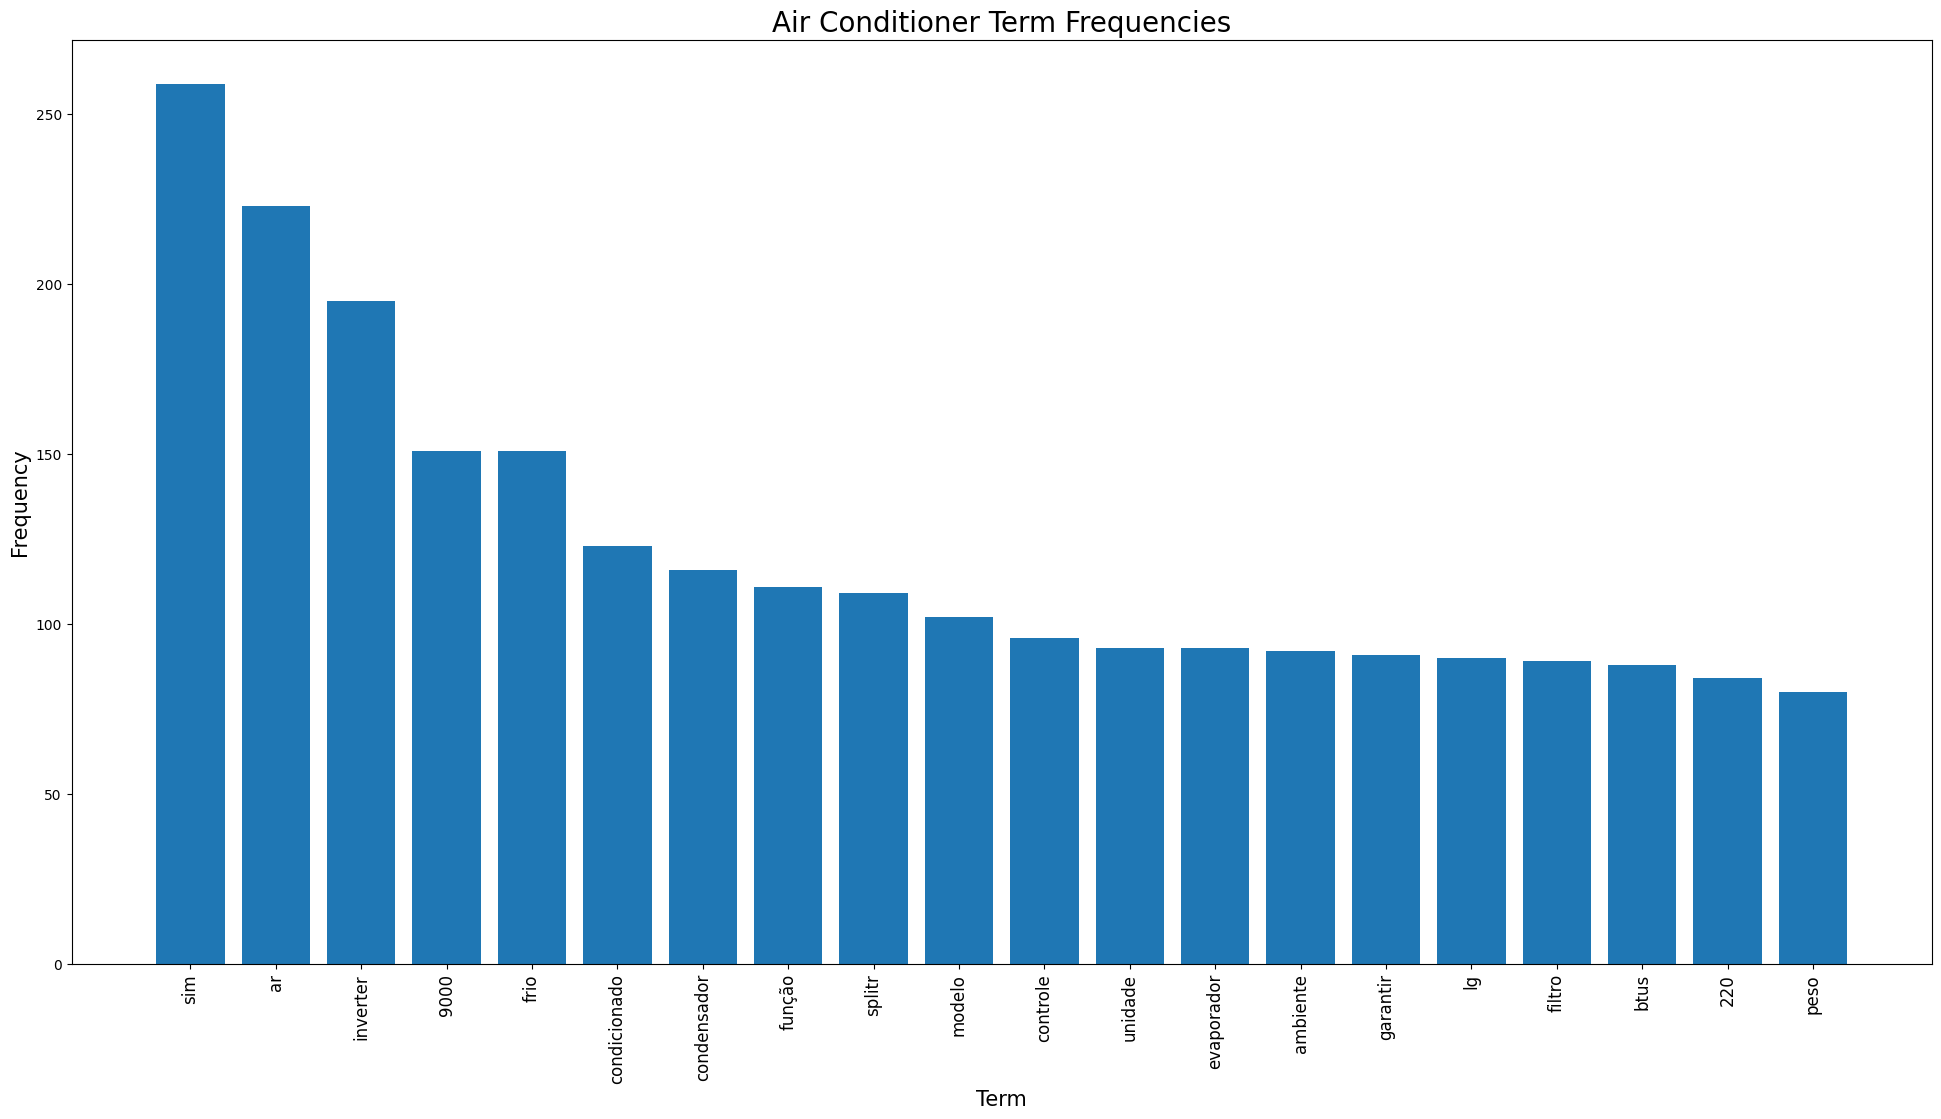

In [142]:
# Word frequency bar chart air conditioner

word_frequency_barchart(
    df.product_information[1:41], "Air Conditioner Term Frequencies")


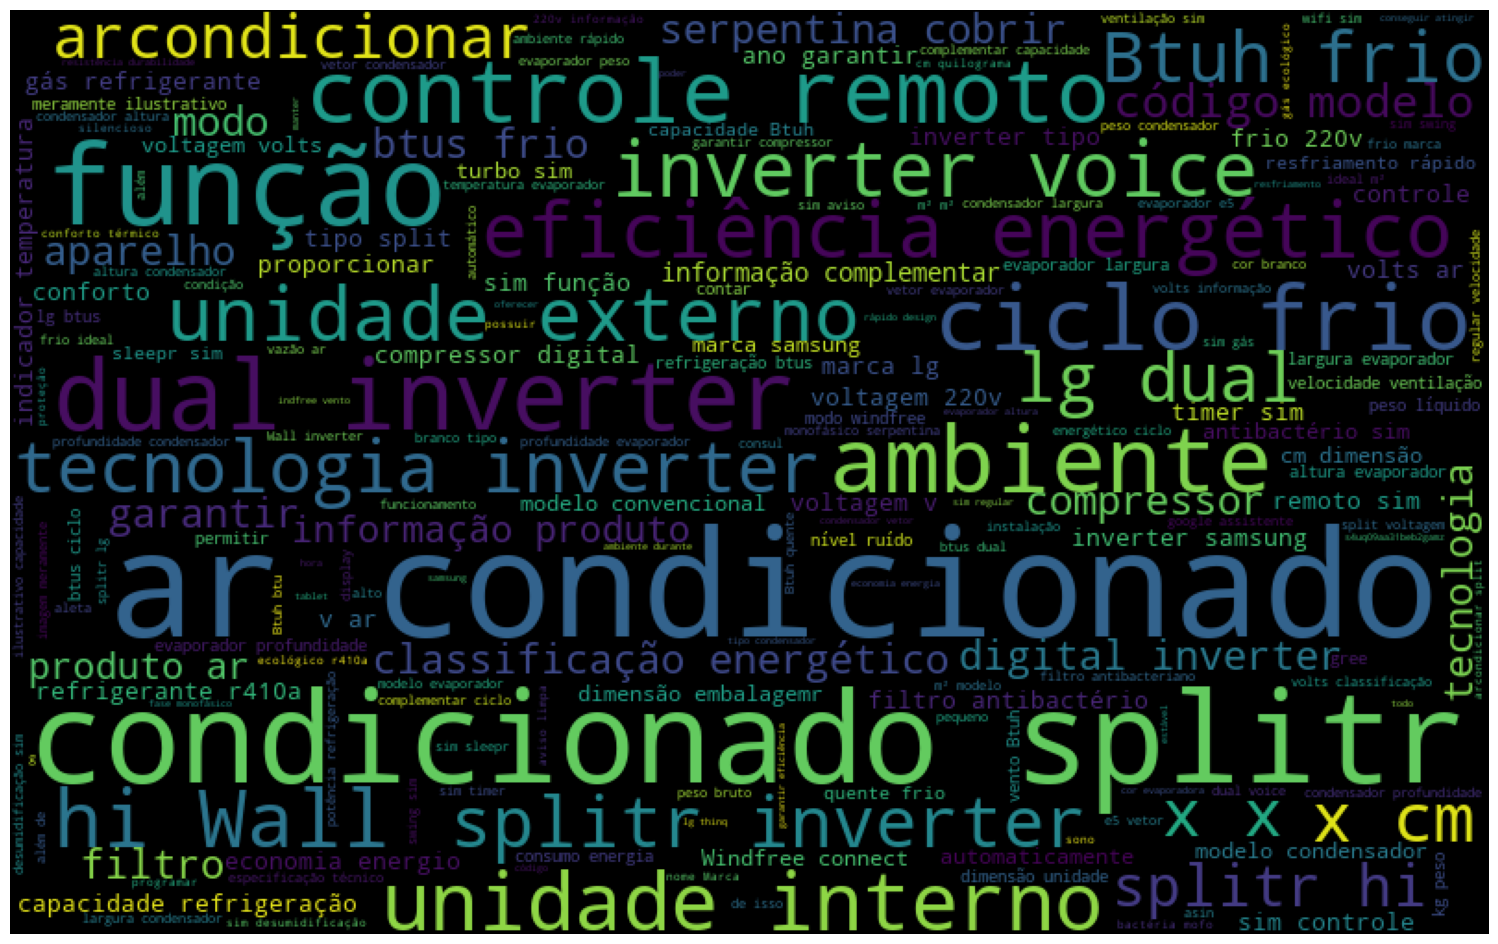

In [138]:
# Wordcloud air conditioner

wordcloud(df.product_information[1:41])

In [143]:
# Word frequency tablet

word_frequency(df.product_information[42:].sample(5))

[('samsung', 3), ('g', 3), ('64', 3), ('gb', 3), ('produto', 3), ('tab', 2), ('Wifi', 2), ('câmerar', 2), ('android', 2), ('104', 2)]
[('01', 5), ('samsung', 4), ('galaxy', 4), ('tab', 4), ('gb', 4), ('tablet', 3), ('Wifi', 3), ('bateria', 3), ('tela', 3), ('A8', 2)]
[('1', 4), ('tamanho', 4), ('101', 3), ('x', 3), ('hennir', 2), ('polegar', 2), ('mtk6592', 2), ('resolução', 2), ('android', 2), ('51', 2)]
[('gb', 8), ('tablet', 7), ('vaio', 6), ('tl10', 6), ('104', 5), ('octacore', 5), ('g', 5), ('teclar', 4), ('128', 4), ('8', 4)]
[('twist', 8), ('tablet', 7), ('tab', 7), ('gb', 6), ('positivo', 5), ('2', 3), ('64', 3), ('7', 3), ('dispositivo', 3), ('oferecer', 3)]


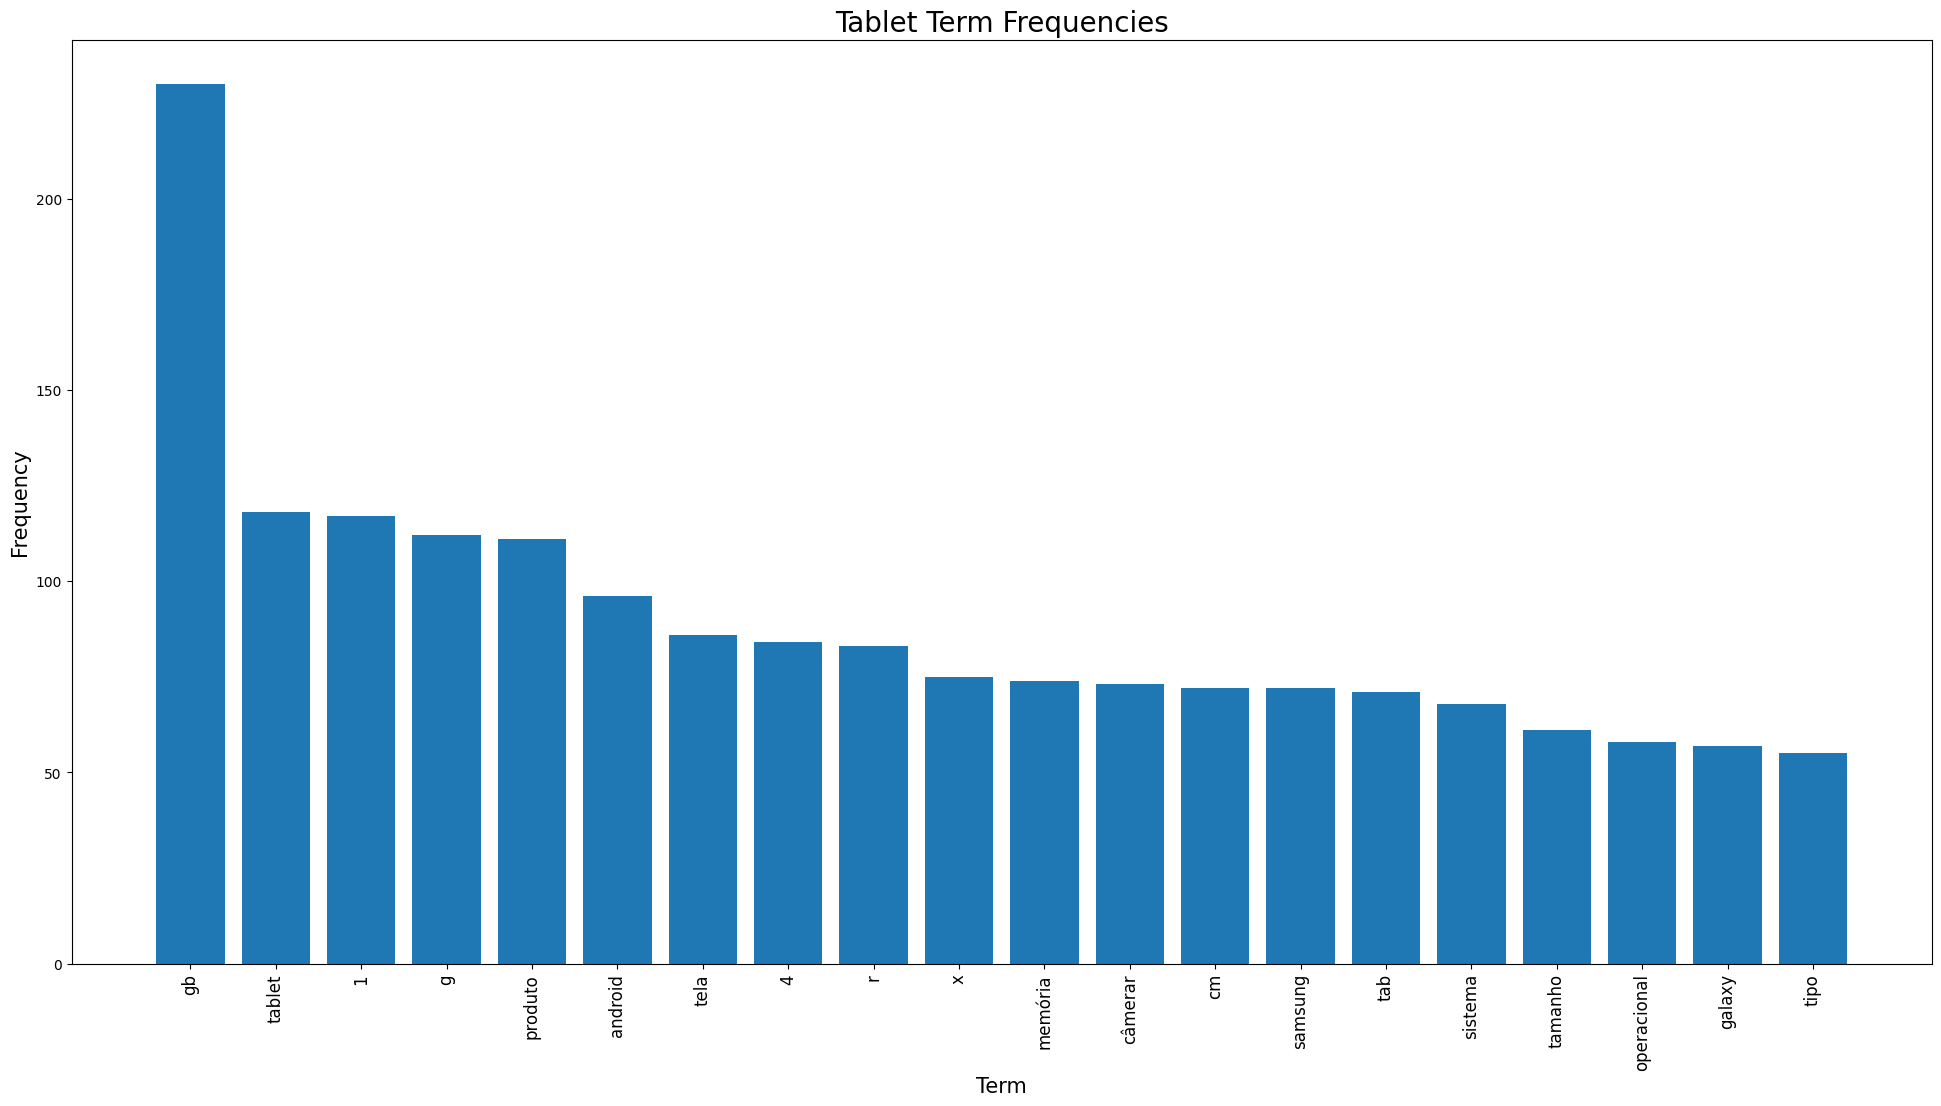

In [146]:
# Word frequency bar chart tablet

word_frequency_barchart(
    df.product_information[42:], "Tablet Term Frequencies")

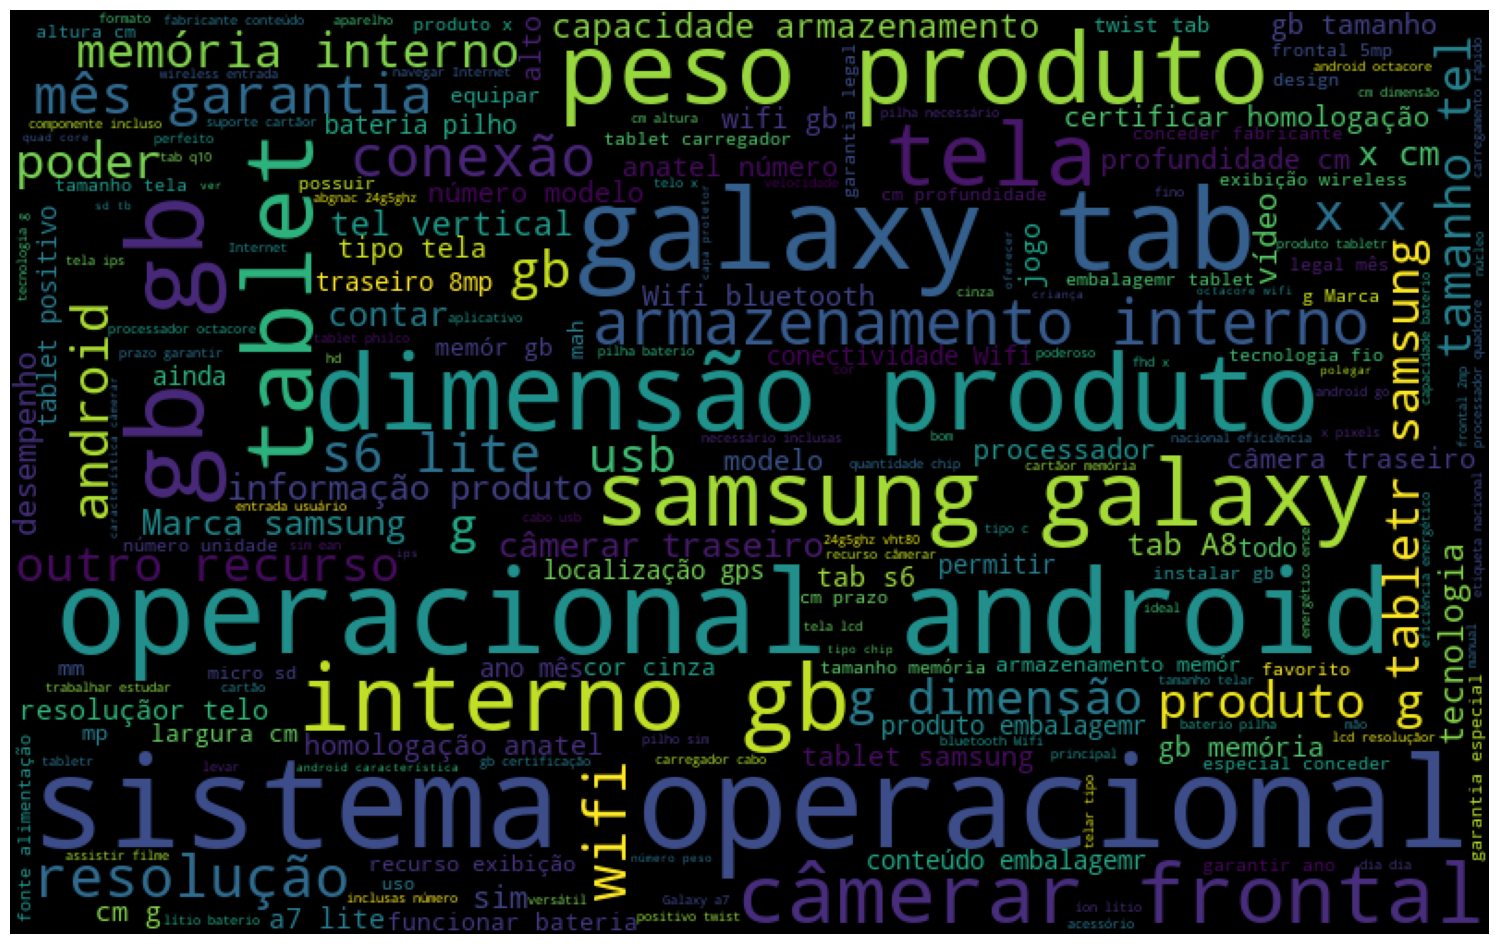

In [145]:
# Wordcloud tablet

wordcloud(df.product_information[42:])


In [69]:
# Vectorize text

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=5)
X = cv.fit_transform(df.product_information).toarray()
y = df.iloc[:, -1].values

len(X[0])


5

## Splitting the dataset into training and test sets

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

X_train, X_test, y_train, y_test


(array([[ 6,  0,  5,  1,  0],
        [ 1,  0,  7,  2,  0],
        [ 2,  0,  0,  2,  0],
        [ 0,  8,  0,  5,  0],
        [ 0,  9,  0,  1,  2],
        [ 0,  8,  0,  4,  0],
        [ 2,  0,  6,  1,  0],
        [ 0,  8,  0,  5,  0],
        [ 0,  8,  0,  7,  3],
        [ 6,  0,  7,  1,  0],
        [ 0,  8,  0,  5,  0],
        [ 8,  0, 16,  4, 12],
        [ 0,  0,  0,  0,  0],
        [ 8,  0,  1,  1,  9],
        [ 0,  4,  0,  2,  0],
        [11,  0, 12,  1, 10],
        [ 0,  5,  0,  3,  0],
        [ 7,  0,  8,  1,  4],
        [ 0,  6,  0,  5,  1],
        [ 3,  0,  4,  2,  0],
        [ 0, 14,  0,  1,  2],
        [ 2,  0,  0,  1,  0],
        [ 9,  0, 13,  2,  8],
        [ 0,  8,  0,  3,  0],
        [ 7,  0,  1,  2, 10],
        [ 6,  0,  4,  1,  7],
        [ 0,  4,  0,  3,  1],
        [ 0,  6,  0,  1,  0],
        [ 4,  0,  4,  1,  0],
        [ 0,  6,  0,  5,  1],
        [ 7,  0,  9,  2, 16],
        [ 7,  0,  8,  1, 12],
        [ 0,  6,  0,  2,  0],
        [ 

## Training the Naive Bayes model

In [75]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB(var_smoothing=1) # var_smoothing regularization to prevent overfitting
classifier.fit(X_train, y_train)


GaussianNB(var_smoothing=1)

## Predicting results from the test set

In [76]:
y_pred = classifier.predict(X_test)

np.concatenate((y_pred.reshape(len(y_pred), 1),
               y_test.reshape(len(y_test), 1)), 1)

array([[123579003, 123579003],
       [  4723356, 123579003],
       [  4723356,   4723356],
       [  4723356,   4723356],
       [  4723356,   4723356],
       [  4723356,   4723356],
       [  4723356,   4723356],
       [  4723356,   4723356],
       [  4723356,   4723356],
       [123579003, 123579003],
       [  4723356,   4723356],
       [123579003, 123579003],
       [123579003, 123579003],
       [123579003, 123579003],
       [  4723356,   4723356],
       [123579003, 123579003]], dtype=int64)

## Confusion Matrix, Accuracy and Classification Report

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(
    f"Confusion Matrix:\n{cm}\n\nAccuracy Score:\n{ac}\n\nClassification Report:\n{cr}")


Confusion Matrix:
[[9 0]
 [1 6]]

Accuracy Score:
0.9375

Classification Report:
              precision    recall  f1-score   support

     4723356       0.90      1.00      0.95         9
   123579003       1.00      0.86      0.92         7

    accuracy                           0.94        16
   macro avg       0.95      0.93      0.94        16
weighted avg       0.94      0.94      0.94        16



## K-fold Cross Validation

In [81]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
print("Accuracy: {:.2f} %".format(accuracies.mean() * 100))
print("Standard Deviation: {:.2f} %".format(accuracies.std() * 100))

Accuracy: 94.05 %
Standard Deviation: 7.32 %
